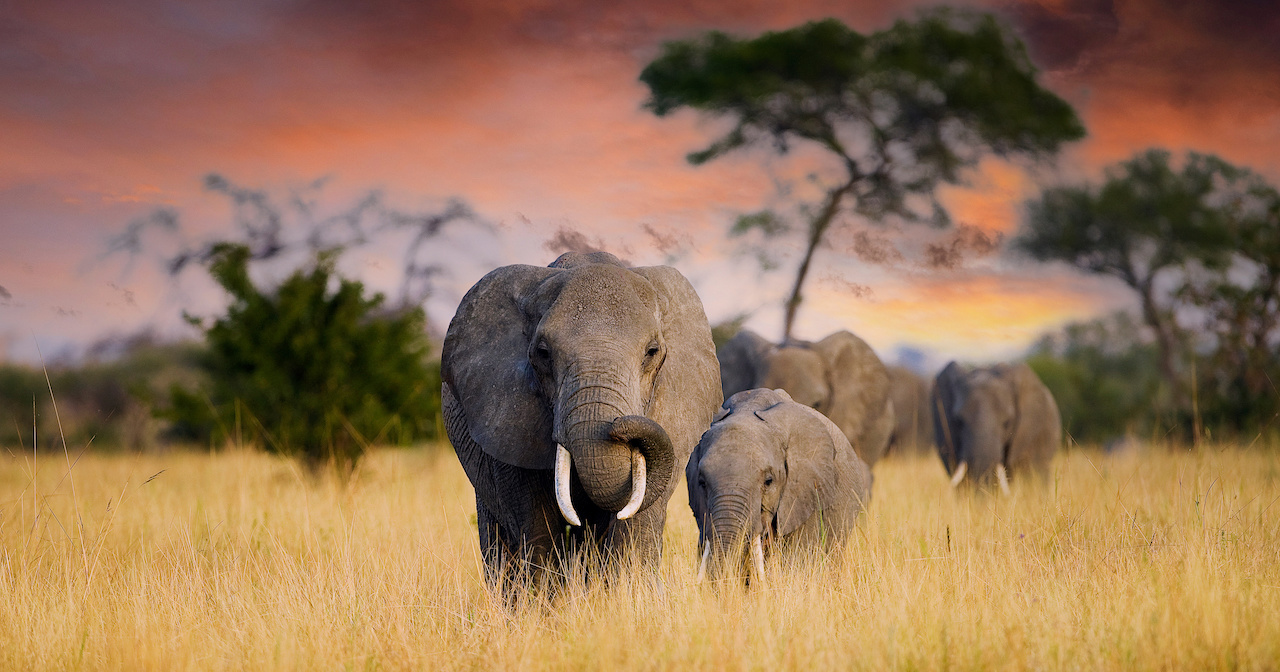
Photo by <a href="https://stock.adobe.com/contributor/19000/mat-hayward?load_type=author&prev_url=detail" >Mat Hayward</a> on Adobe Stock

# Phase 4 Project: *The Met Museum Ivory Art Classification Model*

### By Ryan Posternak and Harrison Carter

Flatiron School, Full-Time Live NYC<br>
Project Presentation Date: August 6th, 2022<br>
Instructor: Joseph Mata

## Goal: Identify whether a piece of artwork among the Met museum's art collection is made of ivory or not

<br>

# Overview and Business Understanding

<br>

Elephants are crucial not only as biological and cultural icons, but as keystone species in their ecosystems. Consisting of  three main species (African Forest, African Savanna, Asian) each serve myriad purposes in their respective environments including habitat creation, seed dispersal, forest pathway creation, brush cover management, among many others. In 1930, an estimated 10 million wild elephants existed on the African continent. After years of poaching and other human intervention that number declined to approximately 496,000 by 2007. In the following seven years their population was further reduced by 30% to 352,271 according to [The Great Elephant Census](https://en.wikipedia.org/wiki/Great_Elephant_Census), the largest wildlife survey in history.

Each year, poachers kill an estimated 20,000 ([WWF](https://www.worldwildlife.org/species/elephant)) wild elephants for illegal trade, mostly dealing in ivory. With so few of these animals remaining, this leaves precious few years for them on the planet. In 2016, many countries including the United States, United Kingdom, Singapore and others implemented a near complete ban on importing and sales of ivory and ivory products. In a massive step, China followed suit the following year, disallowing legal sale of ivory within the country, a move that is "widely regarded as the single biggest step to end the slaughter of elephants"([EIA](https://eia-international.org/wildlife/protecting-elephants/saving-elephants-from-the-ivory-trade/), 2022), "eliminating an estimated 70 percent of the global ivory market." ([Smithsonian Magazine](https://www.smithsonianmag.com/science-nature/faking-elephant-ivory-180963226/)). Unfortunately this is not enough, as consumer imports of ivory from abroad are still allowed. In places like Vietnam and Thailand, the sale of ivory is illegal in name only, with little to no enforcement and street vendors and jewelry shops alike populating their shelves brazenly. This leads to a wholly unregulated market, with over 56 tons of it entering Vietnam's black market and another 20 tons stopped in transit between 2009 and 2018 ([Sustainability Times](https://www.sustainability-times.com/environmental-protection/from-africa-to-vietnam-the-flow-of-ivory-is-relentess/)).



To combat this, wildlife conservationists are constantly urging countries worldwide to enact stricter legislation, but the emergence of online shopping and peer-to-peer marketplaces presents a major roadblock. Although major websites are able to filter out listings by keyword, there is no way to tell if postings under alternate names or pseudonymns contain ivory objects. Here we have created proof of concept for a machine learning model that takes in image data with regards to a three dimensional piece of art and separates those that may contain ivory from those that don't. This can be used to identify listings potentially containing ivory contraband and flag them for further investigation.

# Data Understanding

<br>

# Sourcing the Data

### Import libraries, packages and modules

In [1]:
import numpy as np
import pandas as pd
import requests
import time
import random
from PIL import Image
from io import BytesIO
import os
import shutil

### Connect to Met API

In [2]:
# API URL to obtain IDs of ivory objects
ivory_url = 'https://collectionapi.metmuseum.org/public/collection/v1/search?medium=Ivory&q=*'

# API URL to obtain IDs of (expected to be) non-ivory ceramic objects
non_ivory_url = 'https://collectionapi.metmuseum.org/public/collection/v1/search?medium=Ceramics&hasImages=true&q=*'

# Ivory objects request
ivory_r = requests.get(ivory_url)

# Non-ivory objects request
non_ivory_r = requests.get(non_ivory_url)

ivory_r.status_code, non_ivory_r.status_code

(200, 200)

In [3]:
# Retrieve objectIds
ivory_objectIDs = ivory_r.json()['objectIDs']
non_ivory_objectIDs = non_ivory_r.json()['objectIDs']


print(f"Number of ivory objects: {len(ivory_objectIDs)}")
print(f"Number of ceramic objects: {len(non_ivory_objectIDs)}")

Number of ivory objects: 5975
Number of ceramic objects: 25603


In [4]:
# Let's view the full data on one museum art piece (the first ivory object in our list)
url = 'https://collectionapi.metmuseum.org/public/collection/v1/objects/'

requests.get(url + str(ivory_objectIDs[0])).json()

{'objectID': 248694,
 'isHighlight': False,
 'accessionNumber': '12.229.23b',
 'accessionYear': '1912',
 'isPublicDomain': True,
 'primaryImage': 'https://images.metmuseum.org/CRDImages/gr/original/sf1222923b.jpg',
 'primaryImageSmall': 'https://images.metmuseum.org/CRDImages/gr/web-large/sf1222923b.jpg',
 'additionalImages': [],
 'constituents': None,
 'department': 'Greek and Roman Art',
 'objectName': 'Relief of a duck',
 'title': 'Relief of a duck',
 'culture': 'Roman',
 'period': 'Early Imperial',
 'dynasty': '',
 'reign': '',
 'portfolio': '',
 'artistRole': '',
 'artistPrefix': '',
 'artistDisplayName': '',
 'artistDisplayBio': '',
 'artistSuffix': '',
 'artistAlphaSort': '',
 'artistNationality': '',
 'artistBeginDate': '',
 'artistEndDate': '',
 'artistGender': '',
 'artistWikidata_URL': '',
 'artistULAN_URL': '',
 'objectDate': '1st century A.D.',
 'objectBeginDate': 1,
 'objectEndDate': 99,
 'medium': 'Bone',
 'dimensions': '1 13/16 × 5/8 × 4 3/16 in. (4.7 × 1.6 × 10.6 cm)',

### Create container lists with selected attributes

In [11]:
# Initialize lists
ivory_primaryImageSmall_urls = []
ivory_titles = []
ivory_objectNames = []
ivory_mediums = []
ivory_classifications = []
ivory_departments = []
ivory_cultures = []
ivory_periods = []
ivory_objectDates = []

# Compile containers
attribute_containers = [ivory_primaryImageSmall_urls, ivory_titles, ivory_objectNames, ivory_mediums, 
                        ivory_classifications, ivory_departments, ivory_cultures, ivory_periods, ivory_objectDates]

# Compile key names of attributes
attributes = ['primaryImageSmall', 'title', 'objectName', 'medium', 
              'classification', 'department', 'culture', 'period', 'objectDate']

os.path.join("/", "c:", "sourcedir")


# Execute API requests
objects_url = 'https://collectionapi.metmuseum.org/public/collection/v1/objects/'
#if os.path.isfile('data/final_df.csv') == False:  # Prevent running duplicate API requests
for objectID in ivory_objectIDs:
    r = requests.get(objects_url + str(objectID))
    for attribute_container, attribute in zip(attribute_containers, attributes):
        try:
            attribute_container.append(r.json()[attribute])
        except:
            attribute_container.append(np.nan)  # Some keys are missing on select objects
    time.sleep(1/160)  # Throttle API request rate to conform with API documentation

### Create dataframe of ivory art pieces

In [12]:
ivory_df = pd.DataFrame(ivory_objectIDs, columns=['Object_ID'])

ivory_df['Image_URL'] = ivory_primaryImageSmall_urls
ivory_df['Title'] = ivory_titles
ivory_df['Object_Name'] = ivory_objectNames
ivory_df['Medium'] = ivory_mediums
ivory_df['Classification'] = ivory_classifications
ivory_df['Department'] = ivory_departments
ivory_df['Culture'] = ivory_cultures
ivory_df['Period'] = ivory_periods
ivory_df['Object_Date'] = ivory_objectDates

# Ivory art pieces will have class labels of 1
ivory_df['Target'] = 1

ivory_df.replace(to_replace='', value=np.nan, inplace=True)

print(ivory_df.shape)
ivory_df.head()

(5975, 11)


,Object_ID,Image_URL,Title,Object_Name,Medium,Classification,Department,Culture,Period,Object_Date,Target
0,248694,https://images.metmuseum.org/CRDImages/gr/web-...,Relief of a duck,Relief of a duck,Bone,"Miscellaneous-Bone, Ivory",Greek and Roman Art,Roman,Early Imperial,1st century A.D.,1
1,248695,https://images.metmuseum.org/CRDImages/gr/web-...,Relief of a child,Relief of a child,Bone,"Miscellaneous-Bone, Ivory",Greek and Roman Art,NaN,NaN,NaN,1
2,257575,https://images.metmuseum.org/CRDImages/gr/web-...,Eye inlays,Eye inlays,"Bone, ivory","Miscellaneous-Bone, Ivory",Greek and Roman Art,NaN,NaN,NaN,1
3,25138,NaN,Dirk with Sheath,Dirk with sheath,"Steel, ivory, leather, gold",Daggers,Arms and Armor,French,NaN,16th century,1
4,25137,NaN,Cinquedea,Cinquedea,"Steel, brass, ivory, gold, latten",Daggers,Arms and Armor,Italian,NaN,1525–50,1


In [ ]:
# How many of the ivory objects have valid (small) image URLs?
num_ivory_objects_with_image = ivory_df.shape[0] - ivory_df.Image_URL.isna().sum()
num_ivory_objects_with_image

In [13]:
# Choose 5,975 random objectIds from the non_ivory_objectIDs list
np.random.seed(10)
selected_non_ivory_objectIDs = np.random.choice(non_ivory_objectIDs, size=5975, replace=False)
len(selected_non_ivory_objectIDs)

5975

### Repeat steps above to create dataframe of non-ivory art pieces

In [17]:
non_ivory_primaryImageSmall_urls = []
non_ivory_titles = []
non_ivory_objectNames = []
non_ivory_mediums = []
non_ivory_classifications = []
non_ivory_departments = []
non_ivory_cultures = []
non_ivory_periods = []
non_ivory_objectDates = []

attribute_containers = [non_ivory_primaryImageSmall_urls, non_ivory_titles, non_ivory_objectNames, 
                        non_ivory_mediums, non_ivory_classifications, non_ivory_departments, non_ivory_cultures, 
                        non_ivory_periods, non_ivory_objectDates]

attributes = ['primaryImageSmall', 'title', 'objectName', 'medium', 
              'classification', 'department', 'culture', 'period', 'objectDate']


objects_url = 'https://collectionapi.metmuseum.org/public/collection/v1/objects/'

#if os.path.isfile('data/final_df.csv') == False:  # Prevent running duplicate API requests
for objectID in selected_non_ivory_objectIDs:
    r = requests.get(objects_url + str(objectID))
    for attribute_container, attribute in zip(attribute_containers, attributes):
        try:
            attribute_container.append(r.json()[attribute])
        except:
            attribute_container.append(np.nan)
    time.sleep(1/160)

In [18]:
non_ivory_df = pd.DataFrame(selected_non_ivory_objectIDs, columns=['Object_ID'])

non_ivory_df['Image_URL'] = non_ivory_primaryImageSmall_urls
non_ivory_df['Title'] = non_ivory_titles
non_ivory_df['Object_Name'] = non_ivory_objectNames
non_ivory_df['Medium'] = non_ivory_mediums
non_ivory_df['Classification'] = non_ivory_classifications
non_ivory_df['Department'] = non_ivory_departments
non_ivory_df['Culture'] = non_ivory_cultures
non_ivory_df['Period'] = non_ivory_periods
non_ivory_df['Object_Date'] = non_ivory_objectDates

# Non-ivory art pieces will have class labels of 0
non_ivory_df['Target'] = 0

# Remove objects without valid (small) image URLs
non_ivory_df.replace(to_replace='', value=np.nan, inplace=True)
non_ivory_df.dropna(subset=['Image_URL'], inplace=True)

print(non_ivory_df.shape)
non_ivory_df.head()

(5320, 11)


,Object_ID,Image_URL,Title,Object_Name,Medium,Classification,Department,Culture,Period,Object_Date,Target
0,186685,https://images.metmuseum.org/CRDImages/es/web-...,Bowl with Saint Francis receiving the stigmata,Bowl,"Maiolica (tin-glazed earthenware), lustered",Ceramics-Pottery,European Sculpture and Decorative Arts,NaN,NaN,16th century,0
1,194344,https://images.metmuseum.org/CRDImages/es/web-...,Plate,Plate,Faience (tin-glazed earthenware),Ceramics-Pottery,European Sculpture and Decorative Arts,NaN,NaN,1730–1800,0
2,47555,https://images.metmuseum.org/CRDImages/as/web-...,Plate,Plate,Porcelain,Ceramics,Asian Art,China,Ming dynasty (1368–1644),NaN,0
4,48435,https://images.metmuseum.org/CRDImages/as/web-...,Model of a stove,Model of a stove,Earthenware with green glaze,Tomb Pottery,Asian Art,China,Han dynasty (206 B.C.–A.D. 220),1st–2nd century,0
6,695250,https://images.metmuseum.org/CRDImages/md/web-...,Fragment,Fragment,"Glass, ceramic",Glass-Vessels,Medieval Art,European or Middle Eastern,NaN,ca. 1150–ca. 1250,0


### Concatenate dataframes

In [19]:
merged_df = pd.concat([ivory_df, non_ivory_df], ignore_index=True)
print(merged_df.shape)
merged_df.head()

(11295, 11)


,Object_ID,Image_URL,Title,Object_Name,Medium,Classification,Department,Culture,Period,Object_Date,Target
0,248694,https://images.metmuseum.org/CRDImages/gr/web-...,Relief of a duck,Relief of a duck,Bone,"Miscellaneous-Bone, Ivory",Greek and Roman Art,Roman,Early Imperial,1st century A.D.,1
1,248695,https://images.metmuseum.org/CRDImages/gr/web-...,Relief of a child,Relief of a child,Bone,"Miscellaneous-Bone, Ivory",Greek and Roman Art,NaN,NaN,NaN,1
2,257575,https://images.metmuseum.org/CRDImages/gr/web-...,Eye inlays,Eye inlays,"Bone, ivory","Miscellaneous-Bone, Ivory",Greek and Roman Art,NaN,NaN,NaN,1
3,25138,NaN,Dirk with Sheath,Dirk with sheath,"Steel, ivory, leather, gold",Daggers,Arms and Armor,French,NaN,16th century,1
4,25137,NaN,Cinquedea,Cinquedea,"Steel, brass, ivory, gold, latten",Daggers,Arms and Armor,Italian,NaN,1525–50,1


# Data Preprocessing

### Drop duplicate object IDs, null image URLs, and duplicate image URLs

In [20]:
print('Before preprocessing:' + '\n')

# Search for duplicate Object_IDs
num_dup_IDs = merged_df.loc[merged_df.duplicated(subset='Object_ID', keep=False)].shape[0]
print(str(num_dup_IDs) + ' duplicate Object_IDs')

# Remove from dataframe (keep first occurrence)
dup_ID_indexes = merged_df.loc[merged_df.duplicated(subset='Object_ID', keep=False)].index
merged_df = merged_df.drop(dup_ID_indexes)

# Search for NaN Image_URLs
num_NaN_Image_URLs = merged_df.loc[merged_df['Image_URL'].isna()].shape[0]
print(str(num_NaN_Image_URLs) + ' null Image_URLs')

# Remove from dataframe
NaN_Image_URL_indexes = merged_df.loc[merged_df['Image_URL'].isna()].index
merged_df = merged_df.drop(NaN_Image_URL_indexes)

# Search for duplicate Image_URLs
num_dup_Image_URLs = merged_df.loc[merged_df.duplicated(subset='Image_URL')].shape[0]
print(str(num_dup_Image_URLs) + ' duplicate Image_URLs')

# Remove from dataframe (keep first occurrence)
dup_Image_URL_indexes = merged_df.loc[merged_df.duplicated(subset='Image_URL')].index
merged_df = merged_df.drop(dup_Image_URL_indexes)

print('-'*30)
print('After preprocessing:' + '\n')
print(str(merged_df.loc[merged_df.duplicated(subset='Object_ID', keep=False)].shape[0]) + ' duplicate Object_IDs')
print(str(merged_df.loc[merged_df['Image_URL'].isna()].shape[0]) + ' null Image_URLs')
print(str(merged_df.loc[merged_df.duplicated(subset='Image_URL')].shape[0]) + ' duplicate Image_URLs')

Before preprocessing:

22 duplicate Object_IDs
1358 null Image_URLs
160 duplicate Image_URLs
------------------------------
After preprocessing:

0 duplicate Object_IDs
0 null Image_URLs
0 duplicate Image_URLs


In [21]:
# Let's preview the mediums of our ivory objects
merged_df.loc[merged_df.Target == 1].Medium.value_counts()[:30]

Ivory                                           1382
Watercolor on ivory                              562
Bone                                             140
Bone; incised and inlaid with paint              125
Bone; tinted, incised, and inlaid with paint      53
Elephant ivory                                    53
Bone; carved                                      32
Wood; carved, inlaid with ivory                   31
Ivory (walrus)                                    31
ivory                                             27
Walrus ivory                                      26
Steel, ivory                                      23
Bone; incised                                     23
Ivory with metal mounts                           20
Ivory or bone                                     19
Wood, ivory                                       17
Paper, ivory                                      17
Silver, ivory                                     16
Wood; inlaid with ivory                       

4230
Ivory


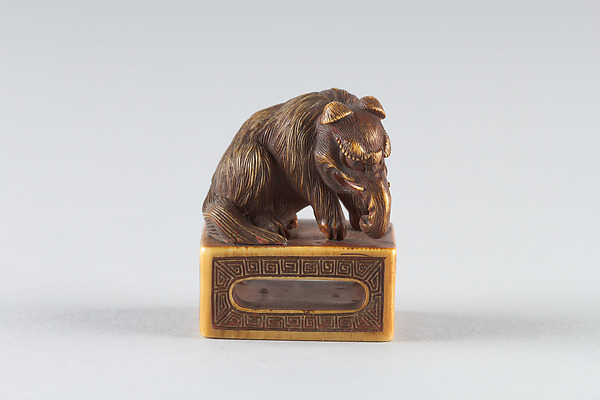

1658
Ivory


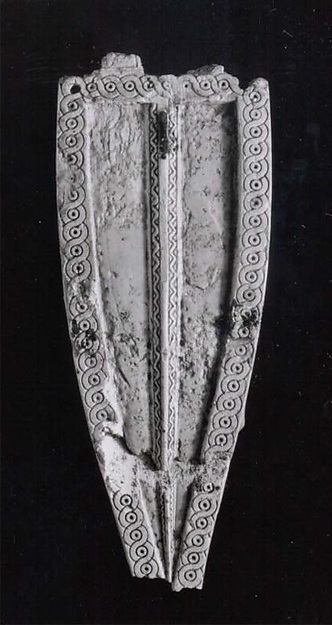

1853
Ivory


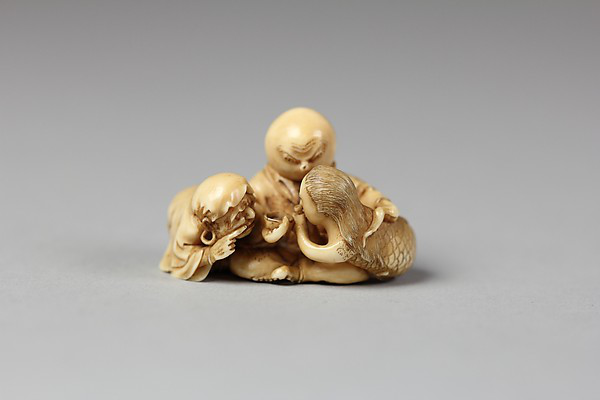

In [23]:
# These are the art mediums that appear most relevant to our search for ivory objects. The others might hardly 
# have any trace of bone/ivory for the model to pick up on
ivory_indexes_to_keep = merged_df.loc[(merged_df.Medium == 'Ivory') | 
                                      (merged_df.Medium == 'Bone') | 
                                      (merged_df.Medium == 'Bone, ivory') | 
                                      (merged_df.Medium == 'Elephant ivory') | 
                                      (merged_df.Medium == 'Bone; carved') | 
                                      (merged_df.Medium == 'Ivory (walrus)') | 
                                      (merged_df.Medium == 'ivory') | 
                                      (merged_df.Medium == 'Walrus ivory') | 
                                      (merged_df.Medium == 'Bone; incised') | 
                                      (merged_df.Medium == 'Ivory with metal mounts') | 
                                      (merged_df.Medium == 'Ivory or bone') | 
                                      (merged_df.Medium == 'Ivory (elephant)')
                                     ].index

# Let's preview three items from above
np.random.seed(42)
for index in np.random.choice(ivory_indexes_to_keep, size=3, replace=False):
    test = requests.get(merged_df.loc[index].Image_URL)
    img_test = Image.open(BytesIO(test.content))
    print(index)
    print(merged_df.loc[index].Medium)
    display(img_test)

970
Wood; carved, inlaid with plain and carved ivory


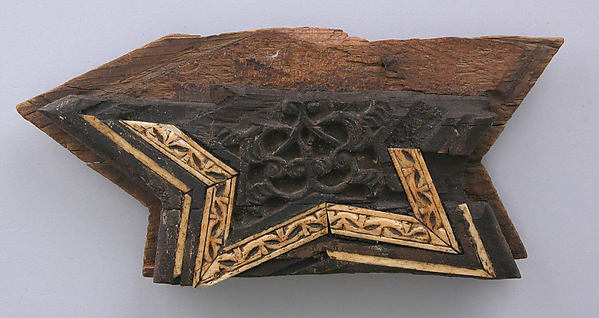

5948
Ivory, gold


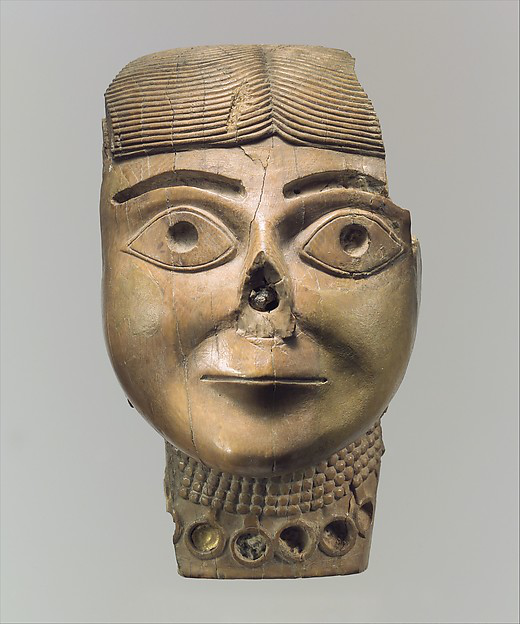

2649
Carved ivory; mounted over wood frame; brass mounts


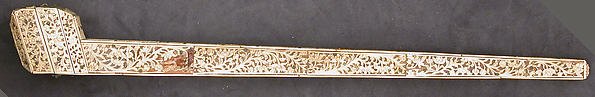

In [24]:
# Just to be sure, let's preview three items that don't fit the medium descriptions above, to see if they are 
# still recognizable as ivory or not
all_ivory_indexes = merged_df.loc[merged_df.Target == 1].index
ivory_indexes_to_drop = [index for index in all_ivory_indexes if index not in ivory_indexes_to_keep]

np.random.seed(42)
for index in np.random.choice(ivory_indexes_to_drop, size=3, replace=False):
    test = requests.get(merged_df.loc[index].Image_URL)
    img_test = Image.open(BytesIO(test.content))
    print(index)
    print(merged_df.loc[index].Medium)
    display(img_test)

**Remarks**:
- As suspected, the images not among the selected mediums appear to have little, if any, traces of ivory, although ivory may be some element of their composition. We'll go ahead and keep only the items among the selected mediums. Even though this will be costly in terms of lost data, these art pieces we're dropping would likely bring more noise than signal.

In [25]:
new_ivory_df = merged_df.loc[ivory_indexes_to_keep]
print(new_ivory_df.shape)
new_ivory_df.head()

(1770, 11)


,Object_ID,Image_URL,Title,Object_Name,Medium,Classification,Department,Culture,Period,Object_Date,Target
0,248694,https://images.metmuseum.org/CRDImages/gr/web-...,Relief of a duck,Relief of a duck,Bone,"Miscellaneous-Bone, Ivory",Greek and Roman Art,Roman,Early Imperial,1st century A.D.,1
1,248695,https://images.metmuseum.org/CRDImages/gr/web-...,Relief of a child,Relief of a child,Bone,"Miscellaneous-Bone, Ivory",Greek and Roman Art,NaN,NaN,NaN,1
2,257575,https://images.metmuseum.org/CRDImages/gr/web-...,Eye inlays,Eye inlays,"Bone, ivory","Miscellaneous-Bone, Ivory",Greek and Roman Art,NaN,NaN,NaN,1
16,31064,https://images.metmuseum.org/CRDImages/aa/web-...,Sword with Scabbard,Sword with scabbard,Ivory,Swords,Arms and Armor,Batak,NaN,16th–19th century,1
72,34077,https://images.metmuseum.org/CRDImages/aa/web-...,Hilt of a Dagger,Hilt of a dagger,Ivory,Daggers,Arms and Armor,"possibly Italian, Venice",NaN,ca. 1300,1


In [26]:
# To maintain a balanced dataset, let's now select 1,770 (random) art pieces from among the non-ivory items

np.random.seed(42)
non_ivory_indexes_to_keep = np.random.choice(merged_df.loc[merged_df['Target'] == 0].index, 
                                             size=1770, 
                                             replace=False)

new_non_ivory_df = merged_df.loc[non_ivory_indexes_to_keep]
print(new_non_ivory_df.shape)
new_non_ivory_df.head()

(1770, 11)


,Object_ID,Image_URL,Title,Object_Name,Medium,Classification,Department,Culture,Period,Object_Date,Target
6398,461221,https://images.metmuseum.org/CRDImages/rl/web-...,Small covered wine pot or teapot,Covered winepot or teapot,Porcelain painted in overglaze famille verte e...,Ceramics,Robert Lehman Collection,Chinese,NaN,1662–1722,0
8492,449783,https://images.metmuseum.org/CRDImages/is/web-...,Bowl,Bowl,"Earthenware; black slip, decoration in white, ...",Ceramics,Islamic Art,NaN,NaN,9th–10th century,0
5998,48118,https://images.metmuseum.org/CRDImages/as/web-...,Bowl,Bowl,Dark brown ware with thick black glaze (Jian w...,Ceramics,Asian Art,China,Yuan dynasty (1271–1368),NaN,0
7342,47949,https://images.metmuseum.org/CRDImages/as/web-...,Jar,Jar,Clay covered with crackled glaze and streaks (...,Ceramics,Asian Art,Japan,Edo (1615–1868) or Meiji period (1868–1912),19th century,0
7432,197911,https://images.metmuseum.org/CRDImages/es/web-...,Plate (assiette à palmes) (1 of 102) (part of ...,Plate,Soft-paste porcelain,Ceramics-Porcelain,European Sculpture and Decorative Arts,NaN,NaN,1787,0


7248
Porcelain painted in overglaze polychrome enamels (Bencharong ware for Thai market)


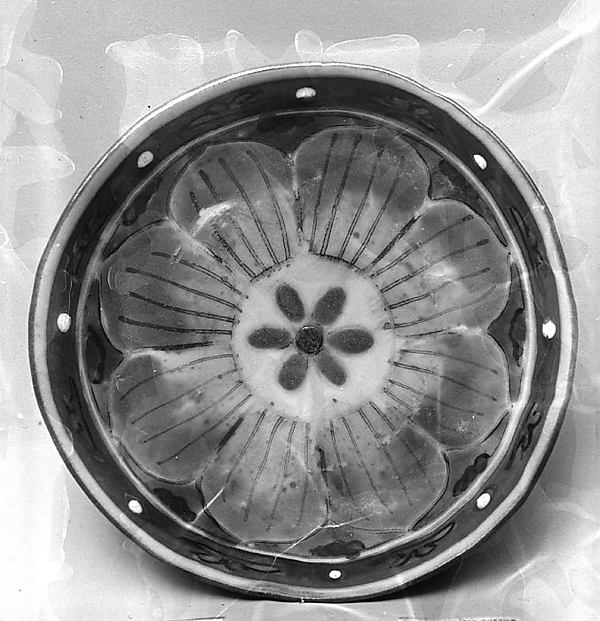

8055
Porcelain with famille verte enamels


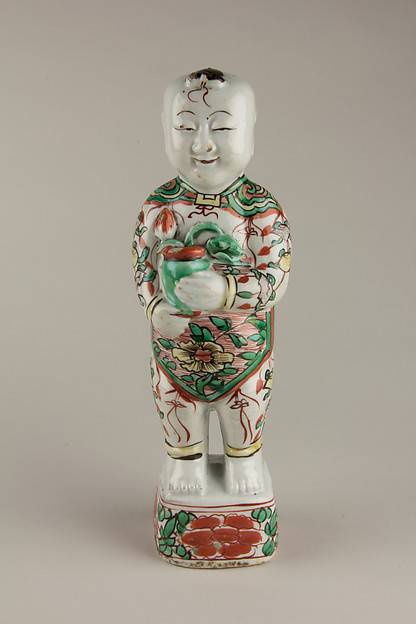

11201
Stoneware with iron-oxide glaze (Jian ware)


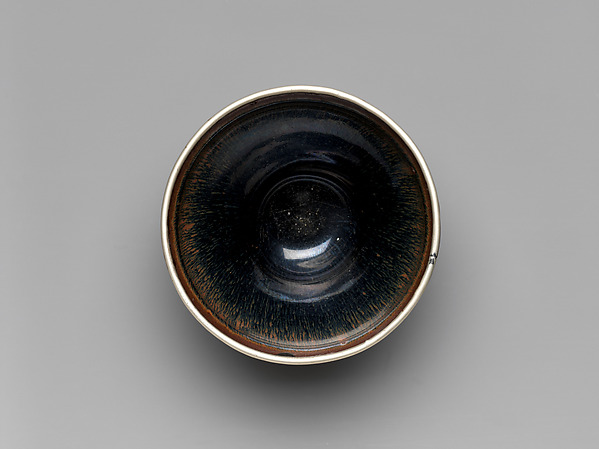

In [27]:
# Let's preview what some non-ivory art pieces look like, to compare
np.random.seed(45)
for index in np.random.choice(non_ivory_indexes_to_keep, size=3, replace=False):
    test = requests.get(merged_df.loc[index].Image_URL)
    img_test = Image.open(BytesIO(test.content))
    print(index)
    print(merged_df.loc[index].Medium)
    display(img_test)

### Concatenate new dataframes

In [28]:
final_df = pd.concat([new_ivory_df, new_non_ivory_df], ignore_index=True)
print(final_df.shape)
final_df.head()

(3540, 11)


,Object_ID,Image_URL,Title,Object_Name,Medium,Classification,Department,Culture,Period,Object_Date,Target
0,248694,https://images.metmuseum.org/CRDImages/gr/web-...,Relief of a duck,Relief of a duck,Bone,"Miscellaneous-Bone, Ivory",Greek and Roman Art,Roman,Early Imperial,1st century A.D.,1
1,248695,https://images.metmuseum.org/CRDImages/gr/web-...,Relief of a child,Relief of a child,Bone,"Miscellaneous-Bone, Ivory",Greek and Roman Art,NaN,NaN,NaN,1
2,257575,https://images.metmuseum.org/CRDImages/gr/web-...,Eye inlays,Eye inlays,"Bone, ivory","Miscellaneous-Bone, Ivory",Greek and Roman Art,NaN,NaN,NaN,1
3,31064,https://images.metmuseum.org/CRDImages/aa/web-...,Sword with Scabbard,Sword with scabbard,Ivory,Swords,Arms and Armor,Batak,NaN,16th–19th century,1
4,34077,https://images.metmuseum.org/CRDImages/aa/web-...,Hilt of a Dagger,Hilt of a dagger,Ivory,Daggers,Arms and Armor,"possibly Italian, Venice",NaN,ca. 1300,1


### Save images to data folder

In [29]:
ivory_indexes = final_df.loc[final_df['Target'] == 1].index
non_ivory_indexes = final_df.loc[final_df['Target'] == 0].index

# Sanity check
ivory_indexes.shape[0] + non_ivory_indexes.shape[0] == final_df.shape[0]

True

In [75]:
final_df.loc[final_df['Target'] == 0].index

Int64Index([1770, 1771, 1772, 1773, 1774, 1775, 1776, 1777, 1778, 1779,
            ...
            3530, 3531, 3532, 3533, 3534, 3535, 3536, 3537, 3538, 3539],
           dtype='int64', length=1770)

In [30]:
ivory_dir_len = len([name for name in os.listdir('data/images/ivory') if not name.endswith('checkpoints')])

unidentified_ivory_images = []

if ivory_dir_len == 0:
    for index in ivory_indexes:
        try:
            response = requests.get(final_df.Image_URL.loc[index])
            img = Image.open(BytesIO(response.content))
            img.save('data/images/ivory/ivory_' + str(merged_df.iloc[index]['Object_ID']) + '.jpg')
        except:
            unidentified_ivory_images.append(index)
        
unidentified_ivory_images

[]

In [31]:
non_ivory_dir_len = len([name for name in os.listdir('data/images/non_ivory') if not name.endswith('checkpoints')])

unidentified_non_ivory_images = []

if non_ivory_dir_len == 0:
    for index in non_ivory_indexes:
        try:
            response = requests.get(final_df.Image_URL.loc[index])
            img = Image.open(BytesIO(response.content))
            img.save('data/images/non_ivory/non_ivory_' + str(merged_df.iloc[index]['Object_ID']) + '.jpg')
        except:
            unidentified_non_ivory_images.append(index)
            
unidentified_non_ivory_images

[]

### Drop rows with invalid image URLs

In [32]:
final_df = final_df.drop(unidentified_ivory_images)
final_df = final_df.drop(unidentified_non_ivory_images)

# Reset indexes
final_df.index = range(len(final_df))

final_df.Target.value_counts()

1    1770
0    1770
Name: Target, dtype: int64

### Save dataframe as .csv file

In [33]:
# if os.path.isfile('data/final_df.csv') == False:
#     final_df.to_csv('data/final_df.csv')
# else:
#     final_df = pd.read_csv('data/final_df.csv', index_col=0)

### Create train, validation, and test splits of ivory and non-ivory images

In [34]:
data_ivory_dir = 'data/images/ivory/'
data_non_ivory_dir = 'data/images/non_ivory/'
split_dir = 'data/split/'

test_ivory = 'data/split/test/ivory/'
test_non_ivory = 'data/split/test/non_ivory/'

validation_ivory = 'data/split/validation/ivory/'
validation_non_ivory = 'data/split/validation/non_ivory/'

train_ivory = 'data/split/train/ivory/'
train_non_ivory = 'data/split/train/non_ivory/'

In [35]:
imgs_ivory = [file for file in os.listdir(data_ivory_dir) if file.endswith('.jpg')]

# Randomize order
random.seed(42)
random.shuffle(imgs_ivory)

print('There are', len(imgs_ivory), 'ivory images')
imgs_ivory[:3]

There are 1769 ivory images


['ivory_170565.jpg', 'ivory_53818.jpg', 'ivory_209774.jpg']

In [36]:
imgs_non_ivory = [file for file in os.listdir(data_non_ivory_dir) if file.endswith('.jpg')]

# Randomize order
random.seed(42)
random.shuffle(imgs_non_ivory)

print('There are', len(imgs_non_ivory), 'non-ivory images')
imgs_non_ivory[:3]

There are 1767 non-ivory images


['non_ivory_42450.jpg', 'non_ivory_59994.jpg', 'non_ivory_450820.jpg']

In [37]:
# We'll do an 80/20 train/test split; of the training data, we'll do another 80/20 train/validation split

print(f"Ivory test images slice:        {int(1769*0.8)+1}:1769  --> {int(1769*0.2)} images")
print(f"Ivory validation images slice:  {int(1415*0.8)+1}:{int(1769*0.8)+1}  --> {int(1415*0.2)} images")
print(f"Ivory train images slice:       0:{int(1415*0.8)+1}     --> {int(1415*0.8)+1} images")

Ivory test images slice:        1416:1769  --> 353 images
Ivory validation images slice:  1133:1416  --> 283 images
Ivory train images slice:       0:1133     --> 1133 images


In [38]:
# Repeat for non-ivory images

print(f"Non-ivory test images slice:        {int(1767*0.8)+1}:1767  --> {int(1767*0.2)} images")
print(f"Non-ivory validation images slice:  {int(1414*0.8)+1}:{int(1767*0.8)+1}  --> {int(1414*0.2)} images")
print(f"Non-ivory train images slice:       0:{int(1414*0.8)+1}     --> {int(1414*0.8)+1} images")

Non-ivory test images slice:        1414:1767  --> 353 images
Non-ivory validation images slice:  1132:1414  --> 282 images
Non-ivory train images slice:       0:1132     --> 1132 images


In [39]:
# Test ivory images
imgs = imgs_ivory[1416:1769]
dir_length = len([name for name in os.listdir('data/split/test/ivory') if not name.endswith('checkpoints')])
if dir_length == 0:
    for img in imgs:
        origin = os.path.join(data_ivory_dir + img)
        destination = os.path.join(test_ivory + img)
        shutil.copyfile(origin, destination)
    
# Validation ivory images
imgs = imgs_ivory[1133:1416]
dir_length = len([name for name in os.listdir('data/split/validation/ivory') if not name.endswith('checkpoints')])
if dir_length == 0:
    for img in imgs:
        origin = os.path.join(data_ivory_dir + img)
        destination = os.path.join(validation_ivory + img)
        shutil.copyfile(origin, destination)
    
# Train ivory images
imgs = imgs_ivory[0:1133]
dir_length = len([name for name in os.listdir('data/split/train/ivory') if not name.endswith('checkpoints')])
if dir_length == 0:
    for img in imgs:
        origin = os.path.join(data_ivory_dir + img)
        destination = os.path.join(train_ivory + img)
        shutil.copyfile(origin, destination)
    
print('There are', len(os.listdir(test_ivory)), 'ivory images in the test set')
print('There are', len(os.listdir(validation_ivory)), 'ivory images in the validation set')
print('There are', len(os.listdir(train_ivory)), 'ivory images in the train set')

There are 353 ivory images in the test set
There are 283 ivory images in the validation set
There are 1133 ivory images in the train set


In [40]:
# Test non-ivory images
imgs = imgs_non_ivory[1414:1767]
dir_length = len([name for name in os.listdir('data/split/test/non_ivory') if not name.endswith('checkpoints')])
if dir_length == 0:
    for img in imgs:
        origin = os.path.join(data_non_ivory_dir + img)
        destination = os.path.join(test_non_ivory + img)
        shutil.copyfile(origin, destination)
    
# Validation non-ivory images
imgs = imgs_non_ivory[1132:1414]
dir_length = len([name for name in os.listdir('data/split/validation/non_ivory') if not name.endswith('checkpoints')])
if dir_length == 0:
    for img in imgs:
        origin = os.path.join(data_non_ivory_dir + img)
        destination = os.path.join(validation_non_ivory + img)
        shutil.copyfile(origin, destination)
    
# Train non-ivory images
imgs = imgs_non_ivory[0:1132]
dir_length = len([name for name in os.listdir('data/split/train/non_ivory') if not name.endswith('checkpoints')])
if dir_length == 0:
    for img in imgs:
        origin = os.path.join(data_non_ivory_dir + img)
        destination = os.path.join(train_non_ivory + img)
        shutil.copyfile(origin, destination)
    
print('There are', len(os.listdir(test_non_ivory)), 'non-ivory images in the test set')
print('There are', len(os.listdir(validation_non_ivory)), 'non-ivory images in the validation set')
print('There are', len(os.listdir(train_non_ivory)), 'non-ivory images in the train set')

There are 353 non-ivory images in the test set
There are 282 non-ivory images in the validation set
There are 1132 non-ivory images in the train set


In [42]:
final_df.head()

,Object_ID,Image_URL,Title,Object_Name,Medium,Classification,Department,Culture,Period,Object_Date,Target
0,248694,https://images.metmuseum.org/CRDImages/gr/web-...,Relief of a duck,Relief of a duck,Bone,"Miscellaneous-Bone, Ivory",Greek and Roman Art,Roman,Early Imperial,1st century A.D.,1
1,248695,https://images.metmuseum.org/CRDImages/gr/web-...,Relief of a child,Relief of a child,Bone,"Miscellaneous-Bone, Ivory",Greek and Roman Art,NaN,NaN,NaN,1
2,257575,https://images.metmuseum.org/CRDImages/gr/web-...,Eye inlays,Eye inlays,"Bone, ivory","Miscellaneous-Bone, Ivory",Greek and Roman Art,NaN,NaN,NaN,1
3,31064,https://images.metmuseum.org/CRDImages/aa/web-...,Sword with Scabbard,Sword with scabbard,Ivory,Swords,Arms and Armor,Batak,NaN,16th–19th century,1
4,34077,https://images.metmuseum.org/CRDImages/aa/web-...,Hilt of a Dagger,Hilt of a dagger,Ivory,Daggers,Arms and Armor,"possibly Italian, Venice",NaN,ca. 1300,1


In [44]:
import seaborn as sns
import matplotlib.pyplot as plt

''

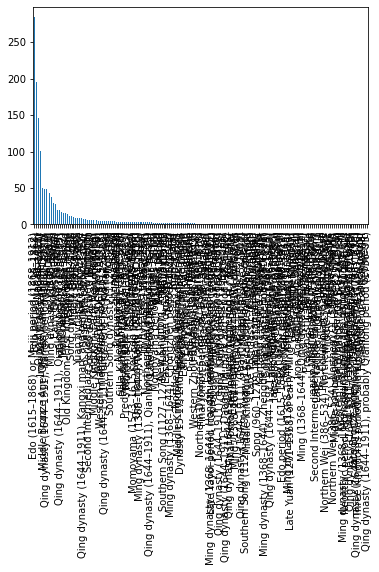

In [48]:
final_df['Period'].value_counts().plot(kind='bar')
;

In [49]:
merged_df.head()

,Object_ID,Image_URL,Title,Object_Name,Medium,Classification,Department,Culture,Period,Object_Date,Target
0,248694,https://images.metmuseum.org/CRDImages/gr/web-...,Relief of a duck,Relief of a duck,Bone,"Miscellaneous-Bone, Ivory",Greek and Roman Art,Roman,Early Imperial,1st century A.D.,1
1,248695,https://images.metmuseum.org/CRDImages/gr/web-...,Relief of a child,Relief of a child,Bone,"Miscellaneous-Bone, Ivory",Greek and Roman Art,NaN,NaN,NaN,1
2,257575,https://images.metmuseum.org/CRDImages/gr/web-...,Eye inlays,Eye inlays,"Bone, ivory","Miscellaneous-Bone, Ivory",Greek and Roman Art,NaN,NaN,NaN,1
10,31163,https://images.metmuseum.org/CRDImages/aa/web-...,Sword (Yatagan) with Scabbard,Sword (Yatagan) with scabbard,"Steel, ivory, copper, gold, coral, emeralds",Swords,Arms and Armor,Turkish,NaN,18th–19th century,1
12,31164,https://images.metmuseum.org/CRDImages/aa/web-...,Sword (Yatagan) with Scabbard,Sword (Yatagan) with scabbard,"Steel, silver, ivory, copper, coral",Swords,Arms and Armor,Turkish,NaN,18th–19th century,1


In [61]:
merged_df['Medium'] = merged_df['Medium'].str.lower()

In [74]:
range(len(merged_df))

range(0, 9755)

In [87]:
for i in merged_df:
    if 'ivory' in merged_df.Medium[i]:
        ivy.append(merged_df.loc(i))

KeyError: 'Object_ID'

In [102]:
ivy = len(merged_df[merged_df['Medium'].str.contains("ivory")])

In [103]:
whale = len(merged_df[merged_df['Medium'].str.contains("whale")])

In [104]:
copper = len(merged_df[merged_df['Medium'].str.contains("copper")])

In [105]:
coral = len(merged_df[merged_df['Medium'].str.contains("coral")])

In [106]:
wood = len(merged_df[merged_df['Medium'].str.contains("wood")])

In [107]:
silver = len(merged_df[merged_df['Medium'].str.contains("silver")])

In [108]:
gold  = len(merged_df[merged_df['Medium'].str.contains("gold")])

In [109]:
pearl = len(merged_df[merged_df['Medium'].str.contains("pearl")])

In [126]:
walrus = len(merged_df[merged_df['Medium'].str.contains("walrus")])

In [127]:
meds_list = [whale, copper, coral, wood, silver, gold, walrus]

In [128]:
meds_list_keys = ['whale', 'copper', 'coral', 'wood', 'silver', 'gold', 'walrus']

In [114]:
meds_dict = dict(zip(meds_list_keys, meds_list))

In [117]:
import matplotlib.pyplot as plt

<BarContainer object of 7 artists>

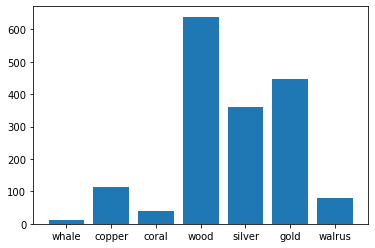

In [129]:
plt.bar(meds_list_keys, meds_list)

In [95]:
copper

,Object_ID,Image_URL,Title,Object_Name,Medium,Classification,Department,Culture,Period,Object_Date,Target
10,31163,https://images.metmuseum.org/CRDImages/aa/web-...,Sword (Yatagan) with Scabbard,Sword (Yatagan) with scabbard,"steel, ivory, copper, gold, coral, emeralds",Swords,Arms and Armor,Turkish,NaN,18th–19th century,1
12,31164,https://images.metmuseum.org/CRDImages/aa/web-...,Sword (Yatagan) with Scabbard,Sword (Yatagan) with scabbard,"steel, silver, ivory, copper, coral",Swords,Arms and Armor,Turkish,NaN,18th–19th century,1
82,25600,https://images.metmuseum.org/CRDImages/aa/web-...,"Crossbow, Cranequin and Six Crossbow Bolts","Crossbow, cranequin and six crossbow bolts","steel, wood (probably cherry, and possibly ser...",Archery Equipment-Crossbows,Arms and Armor,southern German or Tyrolese; cranequin probabl...,NaN,crossbow ca. 1600–1650; cranequin dated 1556,1
360,27933,https://images.metmuseum.org/CRDImages/aa/web-...,Double Sword with Scabbard,Double sword,"steel, ivory, wood, mother-of-pearl, copper, s...",Swords,Arms and Armor,Vietnamese,NaN,18th–19th century,1
380,31587,https://images.metmuseum.org/CRDImages/aa/web-...,Dagger with Sheath (Dah Hmyaung or Dha),Dagger with sheath (Dah Hmyaung or Dha),"steel, ivory, copper, wood, silver, gold",Knives,Arms and Armor,Burmese,NaN,18th century,1
...,...,...,...,...,...,...,...,...,...,...,...
10284,42370,https://images.metmuseum.org/CRDImages/as/web-...,Ewer in Shape of Tibetan Monk’s Cap,Ewer,porcelain painted with copper red under transp...,Ceramics,Asian Art,China,"Qing dynasty (1644–1911), Qianlong mark and pe...",mid-18th century,0
10423,42338,https://images.metmuseum.org/CRDImages/as/web-...,Vase with Phoenix and Peonies,Vase,porcelain painted with cobalt blue and copper ...,Ceramics,Asian Art,China,"Qing dynasty (1644–1911), Kangxi period (1662–...",late 17th century,0
10659,309223,https://images.metmuseum.org/CRDImages/ao/web-...,Copper and Ceramic Beads and Spindle Whorls,Beads,"copper, ceramic",Ceramics-Ornaments,The Michael C. Rockefeller Wing,Peruvian,NaN,A.D. 1200–1470,0
10842,46568,https://images.metmuseum.org/CRDImages/as/web-...,Minature vase,Vase,porcelain with copper red glaze (jingdezhen ware),Ceramics,Asian Art,China,Qing dynasty (1644–1911),18th century,0


In [ ]:
merged_df.loc[]

In [73]:
dfi_lower = merged_df
ivy = []
for i in range(len(merged_df)):
    if 'ivory' in merged_df['Medium'][i]:
        ivy.append(i)

        

KeyError: 3

In [67]:
ivy

[]

## Further Work

- Distinguishing elephant vs mammoth vs walrus ivory - mammoth ivory is unregulated globally and elephant ivory is often passed off as elephant ivory. Walrus ivory is an important economic resource to some North American indigenous tribes.
- Using X-ray data - the refractive  
- 